
# **<center><font style="color:rgb(100,109,254)">Temporal Human Activity Recognition using Spiking Neural Networks in Video Streams</font> </center>**

<center>

## **<font style="color:rgb(134,19,348)"> Outline </font>**

- **`Step 1:` Creating Necessary Environment**
    - **Library Import**

- **`Step 2:` Data Visualization and Labeling**

- **`Step 3:` Dataset Preprocessing**

- **`Step 4:` Data Splitting into Train and Test Sets**

- **`Step 4:` Implement the ConvLSTM Approach**

    - **`Step 4.1:` Construct the Model**
    
    - **`Step 4.2:` Compile & Train the Model**
    
    - **`Step 4.3:` Plot Model’s Loss & Accuracy Curves**

- **`Step 5:` implement the LRCN Approach**
 
    - **`Step 5.1:` Construct the Model**
    
    - **`Step 5.2:` Compile & Train the Model**
    
    - **`Step 5.3:` Plot Model’s Loss & Accuracy Curves**
    
- **`Step 8:` SNN Implementation**

    - **`Step 8.1:` Construct the Model**
    
    - **`Step 8.2:` Compile & Train the Model**
    
    - **`Step 8.3:` Plot Model’s Loss & Accuracy Curves**
    
- **`Step 9:` SNN Model Testing on Video Streams**


### **<font style="color:rgb(134,19,348)"> Import the Libraries</font>**

We will start by installing and importing the required libraries.

In [1]:
# Import the required libraries.
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

And will set `Numpy`, `Python`, and `Tensorflow` seeds to get consistent results on every execution.

In [2]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

## **<font style="color:rgb(134,19,348)">Step 1: Visualize the Data with its Labels</font>**

In the first step, we will visualize the data along with labels to get an idea about what we will be dealing with. We will be using the [Mydataset - Action Recognition Dataset], consisting of realistic videos taken from youtube which differentiates this data set from most of the other available action recognition data sets as they are not realistic and are staged by actors. 

For visualization, we will pick `20` random categories from the dataset and a random video from each selected category and will visualize the first frame of the selected videos with their associated labels written. This way we’ll be able to visualize a subset ( `20` random videos ) of the dataset.

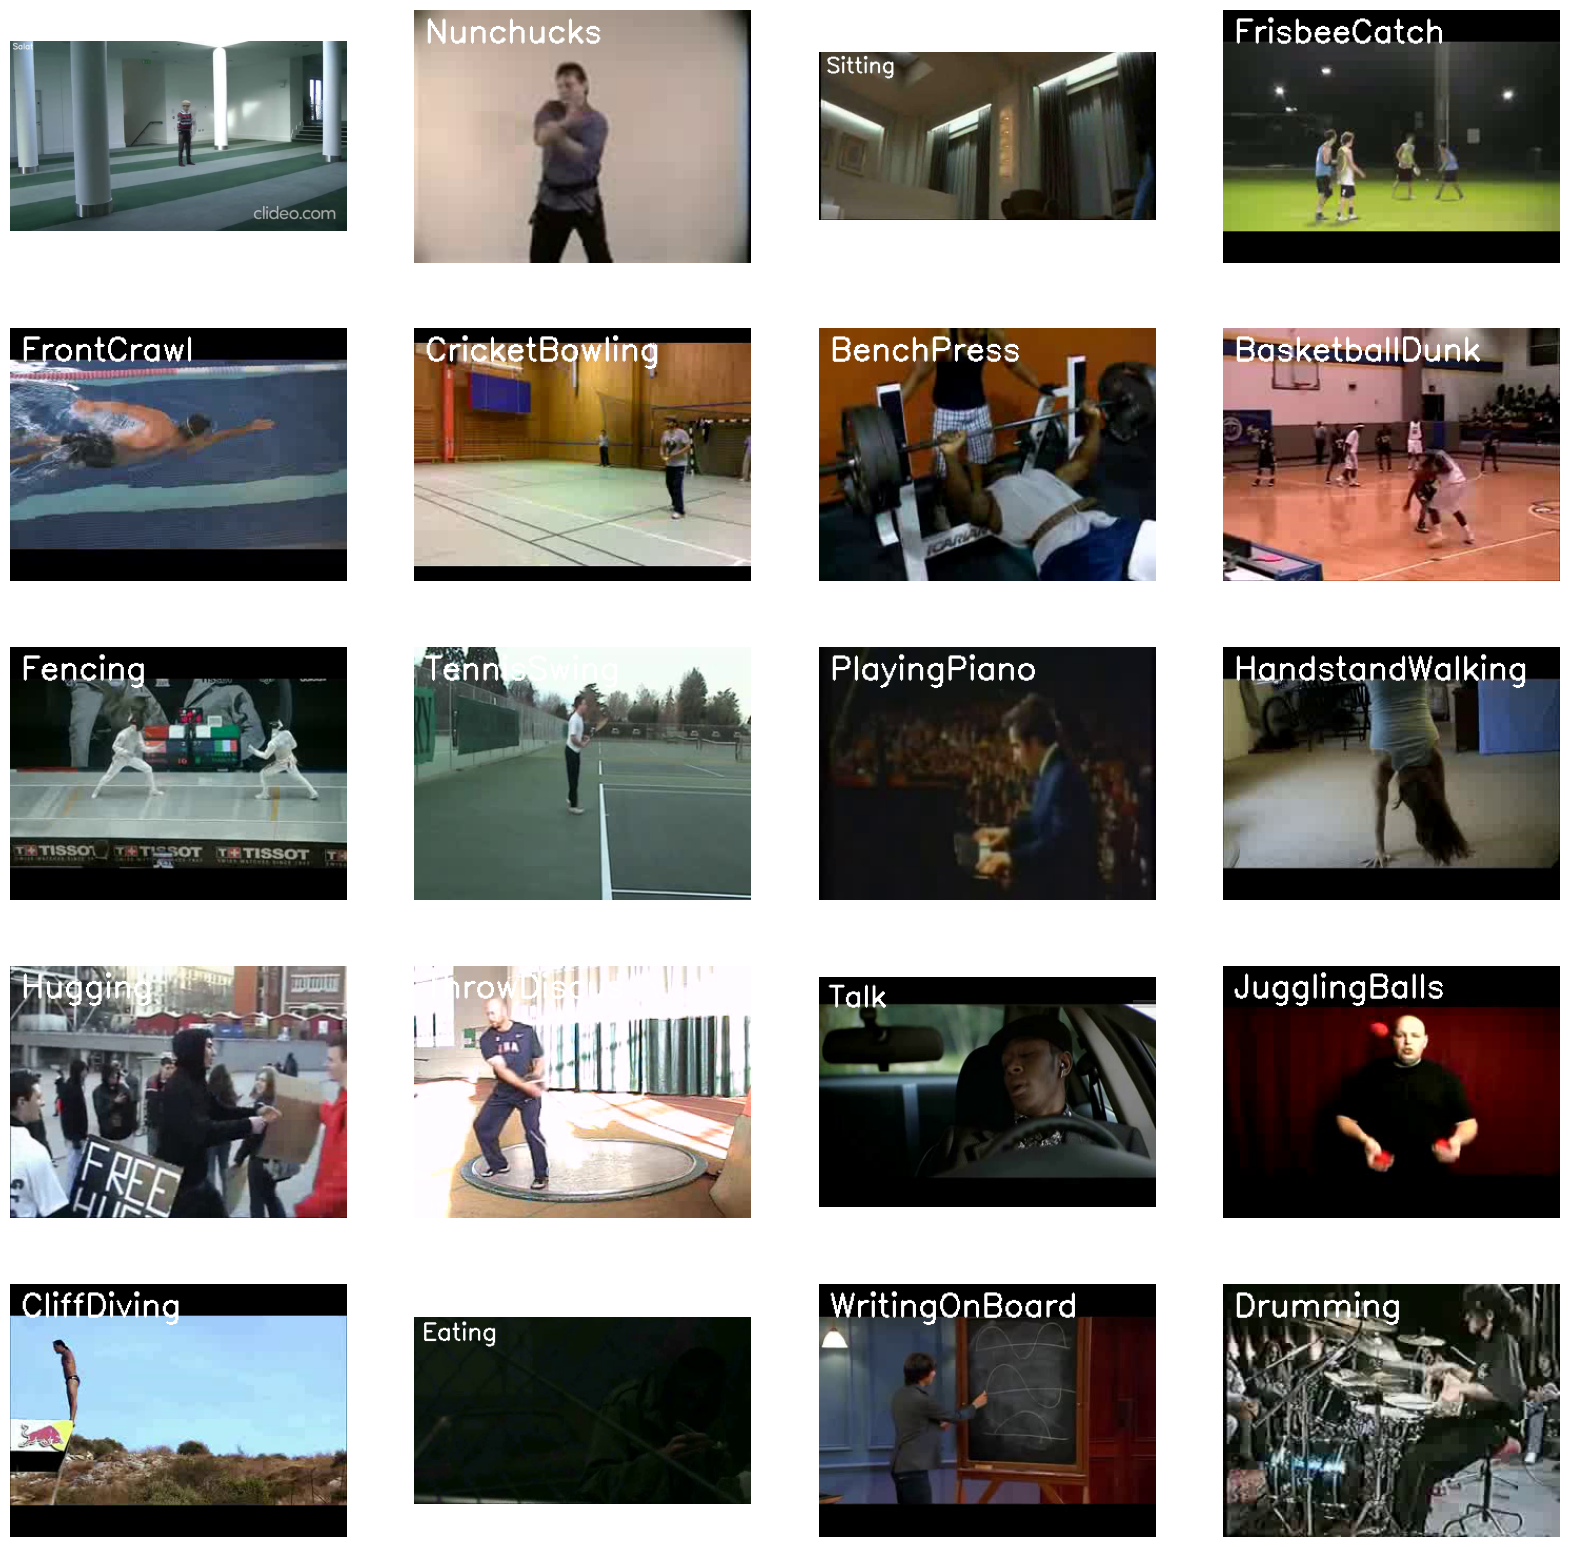

In [3]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

# Get the names of all classes.
all_classes_names = os.listdir('Mydataset')

# Generate a list of 20 random values. The values will be between 0-118, 
# where 118 is the total number of class in the dataset. 
random_range = random.sample(range(len(all_classes_names)), 20)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'Mydataset/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'Mydataset/{selected_class_Name}/{selected_video_file_name}')
    
    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object. 
    video_reader.release()

    # Convert the frame from BGR into RGB format. 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

In [4]:
print(all_classes_names)

['ApplyEyeMakeup', 'ApplyLipstick', 'Archery', 'BabyCrawling', 'BalanceBeam', 'BandMarching', 'BaseballPitch', 'Basketball', 'BasketballDunk', 'BenchPress', 'Biking', 'Billiards', 'BlowDryHair', 'BlowingCandles', 'BodyWeightSquats', 'Bowling', 'BoxingPunchingBag', 'BoxingSpeedBag', 'BreastStroke', 'BrushingTeeth', 'Chewing', 'Clapping', 'CleanAndJerk', 'CliffDiving', 'Counting money', 'CricketBowling', 'CricketShot', 'CuttingInKitchen', 'Diving', 'Drinking', 'Drumming', 'Eating', 'Fencing', 'FieldHockeyPenalty', 'FloorGymnastics', 'FrisbeeCatch', 'FrontCrawl', 'GolfSwing', 'Haircut', 'Hammering', 'HammerThrow', 'HandstandPushups', 'HandstandWalking', 'HeadMassage', 'HighJump', 'HorseRace', 'HorseRiding', 'Hugging', 'HulaHoop', 'IceDancing', 'JavelinThrow', 'JugglingBalls', 'JumpingJack', 'JumpRope', 'Kayaking', 'Knitting', 'LongJump', 'Lunges', 'MilitaryParade', 'Mixing', 'MoppingFloor', 'Nunchucks', 'ParallelBars', 'Pick', 'PlayingCello', 'PlayingDaf', 'PlayingDhol', 'PlayingFlute', '

In [5]:
# Obtenir le nombre de classes
number_of_classes = len(all_classes_names)
print("Number of classes:", number_of_classes)

Number of classes: 118


## **<font style="color:rgb(134,19,348)">Step 2: Preprocess the Dataset</font>**

Next, we will perform some preprocessing on the dataset. First, we will read the video files from the dataset and resize the frames of the videos to a fixed width and height, to reduce the computations and normalized the data to range `[0-1]` by dividing the pixel values with `255`, which makes convergence faster while training the network.

*But first, let's initialize some constants.*

In [6]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

# Specify the directory containing the dataset. 
DATASET_DIR = "Mydataset"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
#CLASSES_LIST = [ 'ApplyEyeMakeup', 'Basketball', 'Biking','CuttingInKitchen','eat','Haircut', 'hug', 'PlayingGuitar','shoot_gun','smile','talk','wave', 'WritingOnBoard']

CLASSES_LIST = ['ApplyEyeMakeup','Basketball','Biking', 'BoxingPunchingBag','Eating', 'HorseRiding','Hugging','PlayingGuitar', 'Rafting','Salat','SalsaSpin','Waving', 'WritingOnBoard']


**Note:** *The **`IMAGE_HEIGHT`**, **`IMAGE_WIDTH`** and **`SEQUENCE_LENGTH`** constants can be increased for better results, although increasing the sequence length is only effective to a certain point, and increasing the values will result in the process being more computationally expensive.*

### **<font style="color:rgb(134,19,348)">Create a Function to Extract, Resize & Normalize Frames</font>**

We will create a function **`frames_extraction()`** that will create a list containing the resized and normalized frames of a video whose path is passed to it as an argument. The function will read the video file frame by frame, although not all frames are added to the list as we will only need an evenly distributed sequence length of frames. 

In [7]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video. 
        success, frame = video_reader.read() 

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()

    # Return the frames list.
    return frames_list

### **<font style="color:rgb(134,19,348)">Create a Function for Dataset Creation</font>**

Now we will create a function **`create_dataset()`** that will iterate through all the classes specified in the **`CLASSES_LIST`** constant and will call the function  **`frame_extraction()`** on every video file of the selected classes and return the frames (**`features`**), class index ( **`labels`**), and video file path (**`video_files_paths`**).

In [8]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
    
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

Now we will utilize the function **`create_dataset()`** created above to extract the data of the selected classes and create the required dataset.

In [9]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: ApplyEyeMakeup


Extracting Data of Class: Basketball
Extracting Data of Class: Biking
Extracting Data of Class: BoxingPunchingBag
Extracting Data of Class: Eating
Extracting Data of Class: HorseRiding
Extracting Data of Class: Hugging
Extracting Data of Class: PlayingGuitar
Extracting Data of Class: Rafting
Extracting Data of Class: Salat
Extracting Data of Class: SalsaSpin
Extracting Data of Class: Waving
Extracting Data of Class: WritingOnBoard


Now we will convert `labels` (class indexes) into one-hot encoded vectors.

In [10]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

## **<font style="color:rgb(134,19,348)">Step 3: Split the Data into Train and Test Set</font>**

As of now, we have the required **`features`** (a NumPy array containing all the extracted frames of the videos) and **`one_hot_encoded_labels`** (also a Numpy array containing all class labels in one hot encoded format). So now, we will split our data to create training and testing sets. We will also shuffle the dataset before the split to avoid any bias and get splits representing the overall distribution of the data.

In [11]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

## **<font style="color:rgb(134,19,348)">Step 4: Implement the ConvLSTM Approach</font>**

In this step, we will implement the first approach by using a combination of ConvLSTM cells. A ConvLSTM cell is a variant of an LSTM network that contains convolutions operations in the network. it is an LSTM with convolution embedded in the architecture, which makes it capable of identifying spatial features of the data while keeping into account the temporal relation. 

<center>
<img src="image/covnlstm.webp" width= 500px>
</center>


For video classification, this approach effectively captures the spatial relation in the individual frames and the temporal relation across the different frames. As a result of this convolution structure, the ConvLSTM is capable of taking in 3-dimensional input `(width, height, num_of_channels)` whereas a simple LSTM only takes in 1-dimensional input hence an LSTM is incompatible for modeling Spatio-temporal data on its own.

### **<font style="color:rgb(134,19,348)">Step 4.1: Construct the Model</font>**


To construct the model, we will use Keras [**`ConvLSTM2D`**](https://keras.io/api/layers/recurrent_layers/conv_lstm2d) recurrent layers. The **`ConvLSTM2D`** layer also takes in the number of filters and kernel size required for applying the convolutional operations. The output of the layers is flattened in the end and is fed to the **`Dense`** layer with softmax activation which outputs the probability of each action category. 

We will also use **`MaxPooling3D`** layers to reduce the dimensions of the frames and avoid unnecessary computations and **`Dropout`** layers to prevent [overfitting](https://en.wikipedia.org/wiki/Overfitting) the model on the data. The architecture is a simple one and has a small number of trainable parameters. This is because we are only dealing with a small subset of the dataset which does not require a large-scale model.

In [12]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(Flatten()) 
    
    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))
    
    ########################################################################################################################
     
    # Display the models summary.
    model.summary()
    
    # Return the constructed convlstm model.
    return model

Now we will utilize the function **`create_convlstm_model()`** created above, to construct the required `convlstm` model.

In [13]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()

# Display the success message. 
print("Model Created Successfully!")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 20, 62, 62, 4)  │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 20, 31, 31, 4)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 20, 31, 31, 4)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 20, 29, 29, 8)  │         3,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 20, 15, 15, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 15, 15, 8)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, 20, 13, 13, 14) │        11,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 20, 7, 7, 14)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 20, 7, 7, 14)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)      │ (None, 20, 5, 5, 16)   │        17,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 20, 3, 3, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2880)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 13)             │        37,453 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,453 (275.21 KB)

 Trainable params: 70,453 (275.21 KB)

 Non-trainable params: 0 (0.00 B)

Model Created Successfully!


#### **<font style="color:rgb(134,19,348)">Check Model’s Structure:</font>**


Now we will use the **`plot_model()`** function, to check the structure of the constructed model, this is helpful while constructing a complex network and making that the network is created correctly.

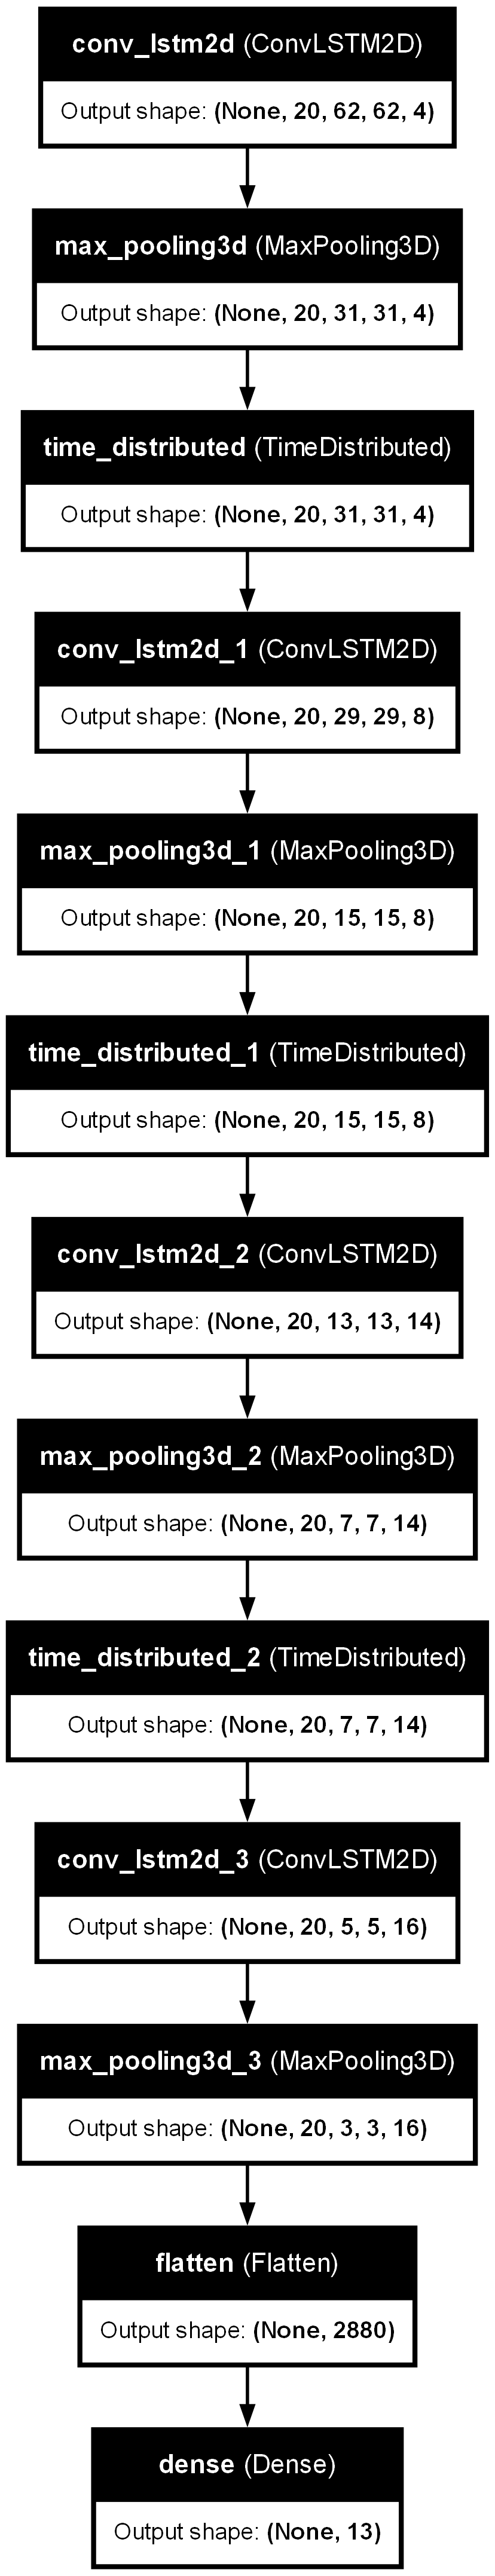

In [14]:
# Plot the structure of the contructed model.
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

### **<font style="color:rgb(134,19,348)">Step 4.2: Compile & Train the Model</font>**

Next, we will add an early stopping callback to prevent [overfitting](https://en.wikipedia.org/wiki/Overfitting) and start the training after compiling the model.

In [15]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4,
                                                     shuffle = True, validation_split = 0.2, 
                                                     callbacks = [early_stopping_callback])

Epoch 1/70
252/252 ━━━━━━━━━━━━━━━━━━━━ 166s 452ms/step - accuracy: 0.1453 - loss: 2.4445 - val_accuracy: 0.3241 - val_loss: 2.1240
Epoch 2/70
252/252 ━━━━━━━━━━━━━━━━━━━━ 104s 414ms/step - accuracy: 0.3959 - loss: 1.7550 - val_accuracy: 0.4229 - val_loss: 1.8288
Epoch 3/70
252/252 ━━━━━━━━━━━━━━━━━━━━ 105s 415ms/step - accuracy: 0.5601 - loss: 1.2980 - val_accuracy: 0.4980 - val_loss: 1.5772
Epoch 4/70
252/252 ━━━━━━━━━━━━━━━━━━━━ 102s 404ms/step - accuracy: 0.6784 - loss: 0.9750 - val_accuracy: 0.5415 - val_loss: 1.5781
Epoch 5/70
252/252 ━━━━━━━━━━━━━━━━━━━━ 103s 407ms/step - accuracy: 0.7418 - loss: 0.7943 - val_accuracy: 0.4545 - val_loss: 1.8775
Epoch 6/70
252/252 ━━━━━━━━━━━━━━━━━━━━ 81s 319ms/step - accuracy: 0.8115 - loss: 0.6007 - val_accuracy: 0.5217 - val_loss: 1.7684
Epoch 7/70
252/252 ━━━━━━━━━━━━━━━━━━━━ 53s 210ms/step - accuracy: 0.8403 - loss: 0.4943 - val_accuracy: 0.6008 - val_loss: 1.5112
Epoch 8/70
252/252 ━━━━━━━━━━━━━━━━━━━━ 47s 188ms/step - accuracy: 0.8824 - lo

#### **<font style="color:rgb(134,19,348)">Evaluate the Trained Model</font>**

After training, we will evaluate the model on the test set.

In [16]:
# Evaluate the trained model.
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 522ms/step - accuracy: 0.6791 - loss: 1.3408


#### **<font style="color:rgb(134,19,348)">Save the Model</font>**

Now we will save the model to avoid training it from scratch every time we need the model.

In [17]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'weight/convlstm_model.h5'

# Save your Model.
convlstm_model.save(model_file_name)

### **<font style="color:rgb(134,19,348)">Step 4.3: Plot Model’s Loss & Accuracy Curves</font>**


Now we will create a function **`plot_metric()`** to visualize the training and validation metrics. We already have separate metrics from our training and validation steps so now we just have to visualize them.

In [18]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

Now we will utilize the function **`plot_metric()`** created above, to visualize and understand the metrics.

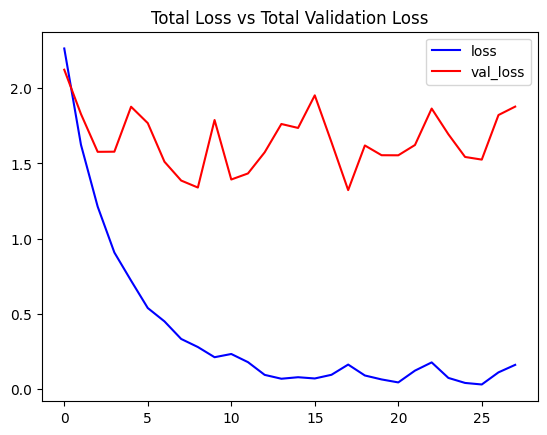

In [19]:
# Visualize the training and validation loss metrices.
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

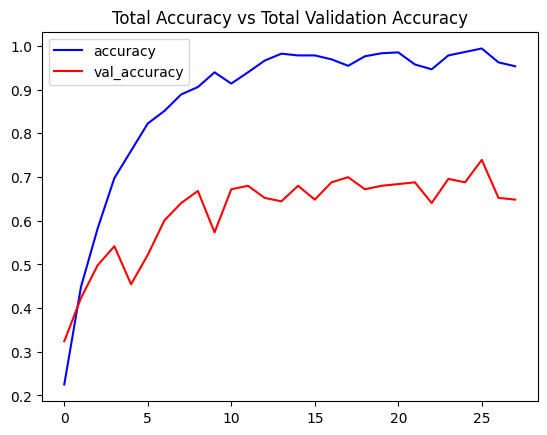

In [20]:
# Visualize the training and validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy') 

## **<font style="color:rgb(134,19,348)">Step 5: Implement the LRCN Approach</font>**

In this step, we will implement the LRCN Approach by combining Convolution and LSTM layers in a single model. Another similar approach can be to use a CNN model and LSTM model trained separately. The CNN model can be used to extract spatial features from the frames in the video, and for this purpose, a pre-trained model can be used, that can be fine-tuned for the problem. And the LSTM model can then use the features extracted by CNN, to predict the action being performed in the video. 


But here, we will implement another approach known as the Long-term Recurrent Convolutional Network (LRCN), which combines CNN and LSTM layers in a single model. The Convolutional layers are used for spatial feature extraction from the frames, and the extracted spatial features are fed to LSTM layer(s) at each time-steps for temporal sequence modeling. This way the network learns spatiotemporal features directly in an end-to-end training, resulting in a robust model.

We will also use [**`TimeDistributed`**](https://keras.io/api/layers/recurrent_layers/time_distributed/) wrapper layer, which allows applying the same layer to every frame of the video independently. So it makes a layer (around which it is wrapped) capable of taking input of shape `(no_of_frames, width, height, num_of_channels)` if originally the layer's input shape was `(width, height, num_of_channels)` which is very beneficial as it allows to input the whole video into the model in a single shot. 

<center>
<img src='image/Screenshot 2021-09-23 074112.png' width=400>
</center>

### **<font style="color:rgb(134,19,348)">Step 5.1: Construct the Model</font>**

To implement our LRCN architecture, we will use time-distributed **`Conv2D`** layers which will be followed by **`MaxPooling2D`** and **`Dropout`** layers. The feature extracted from the **`Conv2D`** layers will be then flattened using the  **`Flatten`** layer and will be fed to a **`LSTM`** layer. The **`Dense`** layer with softmax activation will then use the output from the **`LSTM`** layer to predict the action being performed.

In [21]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()
    
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

Now we will utilize the function **`create_LRCN_model()`** created above to construct the required `LRCN` model.

In [22]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

  super().__init__(**kwargs)



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_3              │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 20, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 20, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 20, 16, 16, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 20, 4, 4, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 20, 4, 4, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 20, 4, 4, 64)   │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 20, 2, 2, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 20, 2, 2, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 20, 2, 2, 64)   │        36,928 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 20, 1, 1, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, 20, 64)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │           429 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,357 (286.55 KB)

 Trainable params: 73,357 (286.55 KB)

 Non-trainable params: 0 (0.00 B)

Model Created Successfully!


#### **<font style="color:rgb(134,19,348)">Check Model’s Structure:</font>**

Now we will use the **`plot_model()`** function to check the structure of the constructed `LRCN` model. As we had checked for the previous model.

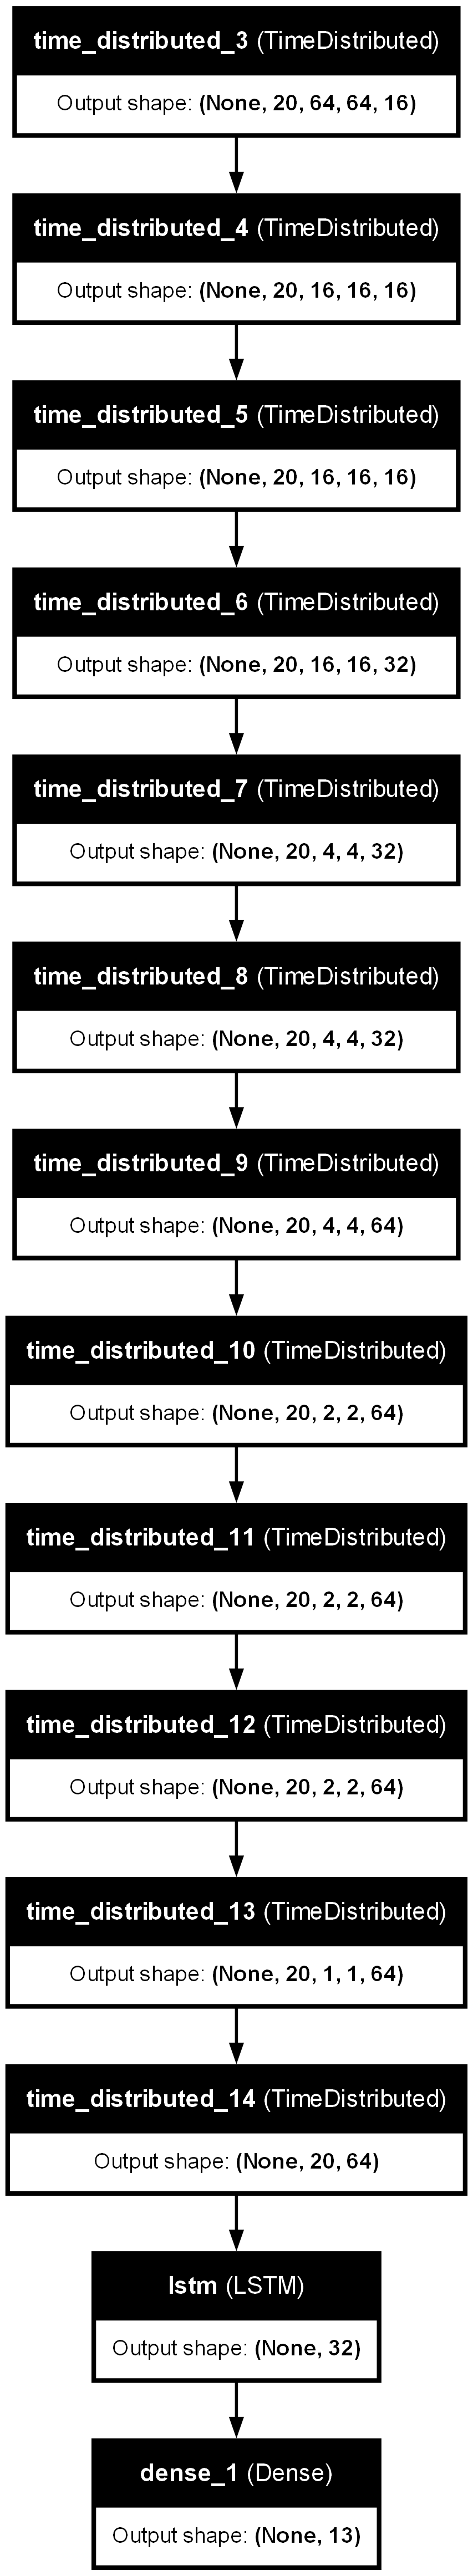

In [23]:
# Plot the structure of the contructed LRCN model.
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

### **<font style="color:rgb(134,19,348)">Step 5.2: Compile & Train the Model</font>**


After checking the structure, we will compile and start training the model.

In [24]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/70
252/252 ━━━━━━━━━━━━━━━━━━━━ 171s 376ms/step - accuracy: 0.0868 - loss: 2.5521 - val_accuracy: 0.1502 - val_loss: 2.4265
Epoch 2/70
252/252 ━━━━━━━━━━━━━━━━━━━━ 79s 312ms/step - accuracy: 0.2145 - loss: 2.2332 - val_accuracy: 0.1976 - val_loss: 2.2028
Epoch 3/70
252/252 ━━━━━━━━━━━━━━━━━━━━ 77s 305ms/step - accuracy: 0.3330 - loss: 1.9446 - val_accuracy: 0.3202 - val_loss: 1.9916
Epoch 4/70
252/252 ━━━━━━━━━━━━━━━━━━━━ 84s 313ms/step - accuracy: 0.4073 - loss: 1.7279 - val_accuracy: 0.3636 - val_loss: 1.8970
Epoch 5/70
237/252 ━━━━━━━━━━━━━━━━━━━━ 4s 273ms/step - accuracy: 0.4099 - loss: 1.6619

#### **<font style="color:rgb(134,19,348)">Evaluating the trained Model</font>**

As done for the previous one, we will evaluate the `LRCN` model on the test set.

In [ ]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.7930 - loss: 0.6987


#### **<font style="color:rgb(134,19,348)">Save the Model</font>**

After that, we will save the model for future uses using the same technique we had used for the previous model.

In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
    
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'weight/LRCN_model.h5'

# Save the Model.
LRCN_model.save(model_file_name)

### **<font style="color:rgb(134,19,348)">Step 5.3: Plot Model’s Loss & Accuracy Curves</font>**

Now we will utilize the function **`plot_metric()`** we had created above to visualize the training and validation metrics of this model.


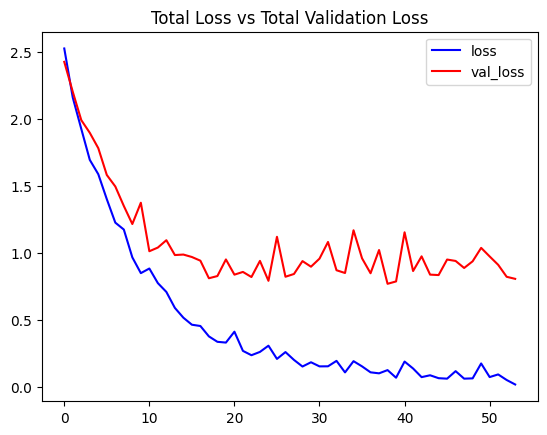

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

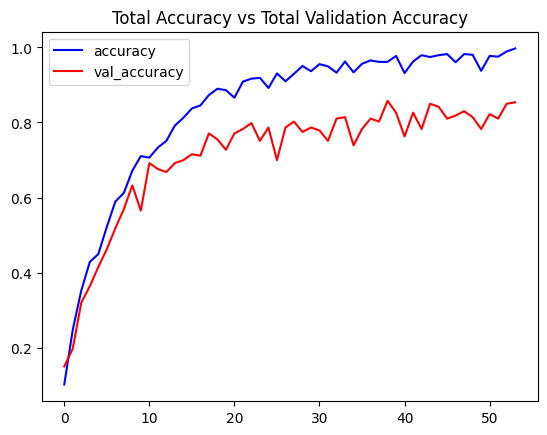

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

## **<font style="color:rgb(134,19,348)">Step 4: Implement the </font>**

In this step, you will develop the Spiking Neural Network. Given the sequential nature of video data and the spatial-temporal relationships within it, utilizing spiking neurons can be particularly beneficial. The construction will involve defining the neuron dynamics, such as the leaky integrate-and-fire model, and the network architecture that includes convolutional spiking layers if necessary.


### **<font style="color:rgb(134,19,348)">Step 5.1: Construct the Model</font>**

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torchsummary import summary

class AvgMeter:
    def __init__(self):
        self.value = 0
        self.number = 0

    def add(self, v, n):
        self.value += v
        self.number += n

    def avg(self):
        return self.value / self.number

class ZIF(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, gamma):
        out = (input > 0).float()
        L = torch.tensor([gamma])
        ctx.save_for_backward(input, out, L)
        return out

    @staticmethod
    def backward(ctx, grad_output):
        input, out, others = ctx.saved_tensors
        gamma = others[0].item()
        grad_input = grad_output.clone()
        tmp = (1 / gamma) * (1 / gamma) * ((gamma - input.abs()).clamp(min=0))
        grad_input = grad_input * tmp
        return grad_input, None

class DSPIKE(nn.Module):
    def __init__(self, region=1.0):
        super(DSPIKE, self).__init__()
        self.region = region

    def forward(self, x, temp):
        out_bp = torch.clamp(x, -self.region, self.region)
        out_bp = (torch.tanh(temp * out_bp)) / (2 * np.tanh(self.region * temp)) + 0.5
        out_s = (x >= 0).float()
        return (out_s.float() - out_bp).detach() + out_bp

class LIFSpike(nn.Module):
    def __init__(self, thresh=0.5, tau=0.5, gamma=1.0, dspike=False, soft_reset=True):
        super(LIFSpike, self).__init__()
        self.act = ZIF.apply if not dspike else DSPIKE(region=1.0)
        self.thresh = thresh
        self.tau = tau
        self.gamma = gamma
        self.soft_reset = soft_reset

    def forward(self, x):
        mem = 0
        spike_out = []
        T = x.shape[2]
        for t in range(T):
            mem = mem * self.tau + x[:, :, t]
            spike = self.act(mem - self.thresh, self.gamma)
            mem = mem - spike * self.thresh if self.soft_reset else (1 - spike) * mem
            spike_out.append(spike)

        return torch.stack(spike_out, dim=2)

class FCN(nn.Module):
    def __init__(self, n_channels, n_classes, out_channels=128, backbone=True):
        super(FCN, self).__init__()

        self.backbone = backbone
        self.conv_block1 = nn.Sequential(
            nn.Conv3d(n_channels, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2, padding=1),
            nn.Dropout(0.35)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2, padding=1)
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv3d(64, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2, padding=1)
        )
        self.dropout = nn.Dropout(0.3)

        self.out_dim = self._get_conv_output_dim(n_channels, (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH))
        if not backbone:
            self.logits = nn.Linear(self.out_dim, n_classes)

    def _get_conv_output_dim(self, n_channels, input_dim):
        dummy_input = torch.zeros(1, n_channels, *input_dim)
        with torch.no_grad():
            output = self.conv_block1(dummy_input)
            output = self.conv_block2(output)
            output = self.conv_block3(output)
        return output.numel()

    def forward(self, x_in):
        x = self.conv_block1(x_in)
        x = self.conv_block2(x)
        x = self.conv_block3(x)

        if self.backbone:
            return None, x
        else:
            x_flat = x.view(x.size(0), -1)
            logits = self.logits(x_flat)
            return logits, x

class SFCN(FCN):
    def __init__(self, n_channels, n_classes, out_channels=128, backbone=True, **kwargs):
        super(SFCN, self).__init__(n_channels, n_classes, out_channels, backbone)
        self.conv_block1 = nn.Sequential(
            nn.Conv3d(n_channels, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm3d(32),
            LIFSpike(**kwargs),
            nn.AvgPool3d(kernel_size=2, stride=2, padding=1),
            nn.Dropout(0.35)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm3d(64),
            LIFSpike(**kwargs),
            nn.AvgPool3d(kernel_size=2, stride=2, padding=1)
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv3d(64, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm3d(out_channels),
            LIFSpike(**kwargs),
            nn.AvgPool3d(kernel_size=2, stride=2, padding=1)
        )

SFCN_model = SFCN(n_channels=3, n_classes=len(CLASSES_LIST), out_channels=128, backbone=False, dspike=True)
summary(SFCN_model, input_size=(3, SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 32, 20, 64, 64]           2,592
       BatchNorm3d-2       [-1, 32, 20, 64, 64]              64
            DSPIKE-3           [-1, 32, 64, 64]               0
            DSPIKE-4           [-1, 32, 64, 64]               0
            DSPIKE-5           [-1, 32, 64, 64]               0
            DSPIKE-6           [-1, 32, 64, 64]               0
            DSPIKE-7           [-1, 32, 64, 64]               0
            DSPIKE-8           [-1, 32, 64, 64]               0
            DSPIKE-9           [-1, 32, 64, 64]               0
           DSPIKE-10           [-1, 32, 64, 64]               0
           DSPIKE-11           [-1, 32, 64, 64]               0
           DSPIKE-12           [-1, 32, 64, 64]               0
           DSPIKE-13           [-1, 32, 64, 64]               0
           DSPIKE-14           [-1, 32,

In [ ]:
# Construct the required SFCN model.
SFCN_model = SFCN(n_channels=3, n_classes=len(CLASSES_LIST), out_channels=128, backbone=False)

# Display the success message.
print("Model Created Successfully!")

Model Created Successfully!


#### **<font style="color:rgb(134,19,348)">Check Model’s Structure:</font>**

In [ ]:
from torchviz import make_dot

# Create a dummy input tensor with the appropriate dimensions
dummy_input = torch.randn(1, 3, SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH)

# Pass the dummy input through the model to create the graph
output = SFCN_model(dummy_input)

# Visualize the model using torchviz
make_dot(output, params=dict(list(SFCN_model.named_parameters()))).render("SFCN_model_structure_plot", format="png")

'SFCN_model_structure_plot.png'

### **<font style="color:rgb(134,19,348)">Step 5.2: Compile & Train the Model</font>**


After checking the structure, we will compile and start training the model.

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

# Convert data to PyTorch tensors
features_train_tensor = torch.tensor(features_train, dtype=torch.float32).permute(0, 4, 1, 2, 3)
features_test_tensor = torch.tensor(features_test, dtype=torch.float32).permute(0, 4, 1, 2, 3)
labels_train_tensor = torch.tensor(labels_train, dtype=torch.float32)
labels_test_tensor = torch.tensor(labels_test, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(features_train_tensor, labels_train_tensor)
test_dataset = TensorDataset(features_test_tensor, labels_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(SFCN_model.parameters(), lr=0.001)

In [ ]:
from tqdm import tqdm
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Define the number of epochs
num_epochs = 50

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
val_accuracies = []

# Training loop with tqdm progress bar
for epoch in range(num_epochs):
    SFCN_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='step'):
        optimizer.zero_grad()
        outputs, _ = SFCN_model(inputs)
        loss = criterion(outputs, labels.argmax(dim=1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.argmax(dim=1)).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)

    # Calculate loss and accuracy on the validation set
    SFCN_model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs, _ = SFCN_model(inputs)
            loss = criterion(outputs, labels.argmax(dim=1))
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.argmax(dim=1)).sum().item()
    
    val_loss /= len(test_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"{len(train_loader)}/{len(train_loader)} - accuracy: {train_accuracy:.4f} - loss: {train_loss:.4f} - val_accuracy: {val_accuracy:.4f} - val_loss: {val_loss:.4f}")



Epoch 1/50: 100%|██████████| 158/158 [10:44<00:00,  4.08s/step]


Epoch 1/50
158/158 - accuracy: 31.7209 - loss: 4.0396 - val_accuracy: 41.8052 - val_loss: 2.7727


Epoch 2/50: 100%|██████████| 158/158 [07:13<00:00,  2.74s/step]


Epoch 2/50
158/158 - accuracy: 51.0706 - loss: 2.2704 - val_accuracy: 43.9430 - val_loss: 2.5441


Epoch 3/50: 100%|██████████| 158/158 [10:16<00:00,  3.90s/step]


Epoch 3/50
158/158 - accuracy: 58.9215 - loss: 1.6827 - val_accuracy: 62.2328 - val_loss: 1.4565


Epoch 4/50: 100%|██████████| 158/158 [15:37<00:00,  5.93s/step]


Epoch 4/50
158/158 - accuracy: 69.3101 - loss: 1.2479 - val_accuracy: 65.0831 - val_loss: 1.4208


Epoch 5/50: 100%|██████████| 158/158 [16:12<00:00,  6.16s/step]


Epoch 5/50
158/158 - accuracy: 78.8263 - loss: 0.7766 - val_accuracy: 69.5962 - val_loss: 1.1569


Epoch 6/50: 100%|██████████| 158/158 [26:24<00:00, 10.03s/step]   


Epoch 6/50
158/158 - accuracy: 83.4259 - loss: 0.5600 - val_accuracy: 69.5962 - val_loss: 1.4770


Epoch 7/50: 100%|██████████| 158/158 [10:37<00:00,  4.03s/step]


Epoch 7/50
158/158 - accuracy: 90.7216 - loss: 0.3008 - val_accuracy: 80.0475 - val_loss: 0.8521


Epoch 8/50: 100%|██████████| 158/158 [15:27<00:00,  5.87s/step]


Epoch 8/50
158/158 - accuracy: 88.2633 - loss: 0.3952 - val_accuracy: 72.2090 - val_loss: 1.1756


Epoch 9/50: 100%|██████████| 158/158 [07:33<00:00,  2.87s/step]


Epoch 9/50
158/158 - accuracy: 90.0872 - loss: 0.3149 - val_accuracy: 71.2589 - val_loss: 1.1695


Epoch 10/50: 100%|██████████| 158/158 [08:39<00:00,  3.29s/step]


Epoch 10/50
158/158 - accuracy: 91.7526 - loss: 0.2445 - val_accuracy: 74.8219 - val_loss: 0.9432


Epoch 11/50: 100%|██████████| 158/158 [14:36<00:00,  5.55s/step]


Epoch 11/50
158/158 - accuracy: 92.0698 - loss: 0.2690 - val_accuracy: 74.1093 - val_loss: 1.1225


Epoch 12/50: 100%|██████████| 158/158 [11:11<00:00,  4.25s/step]


Epoch 12/50
158/158 - accuracy: 93.4972 - loss: 0.2188 - val_accuracy: 71.2589 - val_loss: 1.3650


Epoch 13/50: 100%|██████████| 158/158 [09:23<00:00,  3.57s/step]


Epoch 13/50
158/158 - accuracy: 93.4972 - loss: 0.2311 - val_accuracy: 78.8599 - val_loss: 0.9352


Epoch 14/50: 100%|██████████| 158/158 [10:38<00:00,  4.04s/step]


Epoch 14/50
158/158 - accuracy: 91.9905 - loss: 0.2574 - val_accuracy: 73.3967 - val_loss: 1.2954


Epoch 15/50: 100%|██████████| 158/158 [12:14<00:00,  4.65s/step]


Epoch 15/50
158/158 - accuracy: 96.6693 - loss: 0.0983 - val_accuracy: 78.6223 - val_loss: 0.9398


Epoch 16/50: 100%|██████████| 158/158 [15:46<00:00,  5.99s/step]  


Epoch 16/50
158/158 - accuracy: 96.4314 - loss: 0.1023 - val_accuracy: 79.0974 - val_loss: 0.8611


Epoch 17/50: 100%|██████████| 158/158 [12:11<00:00,  4.63s/step]


Epoch 17/50
158/158 - accuracy: 96.0349 - loss: 0.1215 - val_accuracy: 76.9596 - val_loss: 1.0407


Epoch 18/50: 100%|██████████| 158/158 [15:09<00:00,  5.76s/step]


Epoch 18/50
158/158 - accuracy: 96.7486 - loss: 0.0932 - val_accuracy: 80.5226 - val_loss: 0.8596


Epoch 19/50: 100%|██████████| 158/158 [15:00<00:00,  5.70s/step]


Epoch 19/50
158/158 - accuracy: 97.9381 - loss: 0.0671 - val_accuracy: 76.9596 - val_loss: 1.1143


Epoch 20/50: 100%|██████████| 158/158 [14:38<00:00,  5.56s/step]


Epoch 20/50
158/158 - accuracy: 97.2244 - loss: 0.0912 - val_accuracy: 77.9097 - val_loss: 1.1731


Epoch 21/50: 100%|██████████| 158/158 [14:22<00:00,  5.46s/step]


Epoch 21/50
158/158 - accuracy: 94.9247 - loss: 0.1452 - val_accuracy: 69.1211 - val_loss: 1.6797


Epoch 22/50: 100%|██████████| 158/158 [14:52<00:00,  5.65s/step]


Epoch 22/50
158/158 - accuracy: 92.9421 - loss: 0.2533 - val_accuracy: 74.8219 - val_loss: 1.3040


Epoch 23/50: 100%|██████████| 158/158 [14:16<00:00,  5.42s/step]


Epoch 23/50
158/158 - accuracy: 93.6558 - loss: 0.2495 - val_accuracy: 74.1093 - val_loss: 1.4089


Epoch 24/50: 100%|██████████| 158/158 [14:32<00:00,  5.52s/step]


Epoch 24/50
158/158 - accuracy: 97.3037 - loss: 0.0829 - val_accuracy: 77.6722 - val_loss: 1.0907


Epoch 25/50: 100%|██████████| 158/158 [12:37<00:00,  4.79s/step]


Epoch 25/50
158/158 - accuracy: 98.6519 - loss: 0.0464 - val_accuracy: 77.9097 - val_loss: 0.9830


Epoch 26/50: 100%|██████████| 158/158 [16:56<00:00,  6.43s/step] 


Epoch 26/50
158/158 - accuracy: 98.8898 - loss: 0.0258 - val_accuracy: 76.2470 - val_loss: 1.3340


Epoch 27/50: 100%|██████████| 158/158 [29:30<00:00, 11.20s/step]   


Epoch 27/50
158/158 - accuracy: 98.3347 - loss: 0.0541 - val_accuracy: 79.3349 - val_loss: 1.1294


Epoch 28/50: 100%|██████████| 158/158 [13:17<00:00,  5.05s/step] 


Epoch 28/50
158/158 - accuracy: 98.1761 - loss: 0.0554 - val_accuracy: 77.9097 - val_loss: 1.0129


Epoch 29/50: 100%|██████████| 158/158 [09:59<00:00,  3.79s/step]


Epoch 29/50
158/158 - accuracy: 98.0174 - loss: 0.0699 - val_accuracy: 80.0475 - val_loss: 1.1597


Epoch 30/50: 100%|██████████| 158/158 [10:43<00:00,  4.07s/step]


Epoch 30/50
158/158 - accuracy: 94.6075 - loss: 0.1790 - val_accuracy: 72.6841 - val_loss: 1.7711


Epoch 31/50: 100%|██████████| 158/158 [11:51<00:00,  4.51s/step]


Epoch 31/50
158/158 - accuracy: 98.0967 - loss: 0.0529 - val_accuracy: 83.3729 - val_loss: 0.9937


Epoch 32/50: 100%|██████████| 158/158 [10:22<00:00,  3.94s/step]


Epoch 32/50
158/158 - accuracy: 97.1451 - loss: 0.0951 - val_accuracy: 79.3349 - val_loss: 1.1966


Epoch 33/50: 100%|██████████| 158/158 [09:54<00:00,  3.77s/step]


Epoch 33/50
158/158 - accuracy: 98.7312 - loss: 0.0399 - val_accuracy: 80.9976 - val_loss: 1.0349


Epoch 34/50: 100%|██████████| 158/158 [09:58<00:00,  3.79s/step]


Epoch 34/50
158/158 - accuracy: 98.4140 - loss: 0.0464 - val_accuracy: 80.9976 - val_loss: 0.9824


Epoch 35/50: 100%|██████████| 158/158 [14:27<00:00,  5.49s/step]


Epoch 35/50
158/158 - accuracy: 97.5416 - loss: 0.0648 - val_accuracy: 77.1971 - val_loss: 1.1820


Epoch 36/50: 100%|██████████| 158/158 [14:27<00:00,  5.49s/step]


Epoch 36/50
158/158 - accuracy: 98.8105 - loss: 0.0402 - val_accuracy: 85.9857 - val_loss: 0.7487


Epoch 37/50: 100%|██████████| 158/158 [14:19<00:00,  5.44s/step]


Epoch 37/50
158/158 - accuracy: 98.5726 - loss: 0.0566 - val_accuracy: 81.2352 - val_loss: 1.0599


Epoch 38/50: 100%|██████████| 158/158 [14:51<00:00,  5.65s/step]


Epoch 38/50
158/158 - accuracy: 99.2863 - loss: 0.0189 - val_accuracy: 81.7102 - val_loss: 1.0247


Epoch 39/50: 100%|██████████| 158/158 [11:49<00:00,  4.49s/step]


Epoch 39/50
158/158 - accuracy: 99.5242 - loss: 0.0134 - val_accuracy: 82.1853 - val_loss: 0.9446


Epoch 40/50: 100%|██████████| 158/158 [15:23<00:00,  5.84s/step]


Epoch 40/50
158/158 - accuracy: 98.4933 - loss: 0.0372 - val_accuracy: 81.2352 - val_loss: 1.0884


Epoch 41/50: 100%|██████████| 158/158 [13:21<00:00,  5.07s/step]


Epoch 41/50
158/158 - accuracy: 97.5416 - loss: 0.0744 - val_accuracy: 80.0475 - val_loss: 1.1692


Epoch 42/50: 100%|██████████| 158/158 [08:50<00:00,  3.36s/step]


Epoch 42/50
158/158 - accuracy: 96.0349 - loss: 0.1377 - val_accuracy: 80.7601 - val_loss: 1.2400


Epoch 43/50: 100%|██████████| 158/158 [13:25<00:00,  5.10s/step]


Epoch 43/50
158/158 - accuracy: 99.2070 - loss: 0.0332 - val_accuracy: 79.8100 - val_loss: 1.2434


Epoch 44/50: 100%|██████████| 158/158 [08:52<00:00,  3.37s/step]


Epoch 44/50
158/158 - accuracy: 98.7312 - loss: 0.0440 - val_accuracy: 82.1853 - val_loss: 1.0640


Epoch 45/50: 100%|██████████| 158/158 [08:03<00:00,  3.06s/step]


Epoch 45/50
158/158 - accuracy: 99.1277 - loss: 0.0258 - val_accuracy: 83.6105 - val_loss: 1.0177


Epoch 46/50: 100%|██████████| 158/158 [08:06<00:00,  3.08s/step]


Epoch 46/50
158/158 - accuracy: 97.8588 - loss: 0.0666 - val_accuracy: 77.1971 - val_loss: 1.2757


Epoch 47/50: 100%|██████████| 158/158 [08:41<00:00,  3.30s/step]


Epoch 47/50
158/158 - accuracy: 98.8898 - loss: 0.0388 - val_accuracy: 72.9216 - val_loss: 2.1235


Epoch 48/50: 100%|██████████| 158/158 [07:53<00:00,  3.00s/step]


Epoch 48/50
158/158 - accuracy: 97.3037 - loss: 0.0856 - val_accuracy: 80.5226 - val_loss: 1.0033


Epoch 49/50: 100%|██████████| 158/158 [08:21<00:00,  3.18s/step]


Epoch 49/50
158/158 - accuracy: 98.9691 - loss: 0.0325 - val_accuracy: 82.8979 - val_loss: 0.9329


Epoch 50/50: 100%|██████████| 158/158 [11:09<00:00,  4.24s/step]


Epoch 50/50
158/158 - accuracy: 99.6828 - loss: 0.0106 - val_accuracy: 85.0356 - val_loss: 0.9749


#### **<font style="color:rgb(134,19,348)">Evaluate the Trained Model</font>**

After training, we will evaluate the model on the test set.

In [ ]:
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Evaluation
SFCN_model.eval()
correct = 0
total = 0
val_loss = 0.0

# Use tqdm to create a progress bar
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc='Evaluating', unit='step'):
        outputs, _ = SFCN_model(inputs)
        loss = criterion(outputs, labels.argmax(dim=1))
        val_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.argmax(dim=1)).sum().item()

# Calculate average loss and accuracy
val_loss /= len(test_loader)
val_accuracy = 100 * correct / total

# Print final evaluation results
print(f"Evaluation Results: {len(test_loader)}/{len(test_loader)} - accuracy: {val_accuracy:.4f}% - loss: {val_loss:.4f}")


Evaluating: 100%|██████████| 53/53 [00:27<00:00,  1.95step/s]

Evaluation Results: 53/53 - accuracy: 85.0356% - loss: 0.9749


#### **<font style="color:rgb(134,19,348)">Save the Model</font>**

After that, we will save the model for future uses using the same technique we had used for the previous model.

In [ ]:
# Save the model
torch.save(SFCN_model.state_dict(), "weight/SFCN_model.h5")
print("Model saved to SFCN_model.h5")


Model saved to SFCN_model.h5


### **<font style="color:rgb(134,19,348)">Step 5.3: Plot Model’s Loss & Accuracy Curves</font>**

Now we will utilize the function **`plot_metric()`** we had created above to visualize the training and validation metrics of this model.


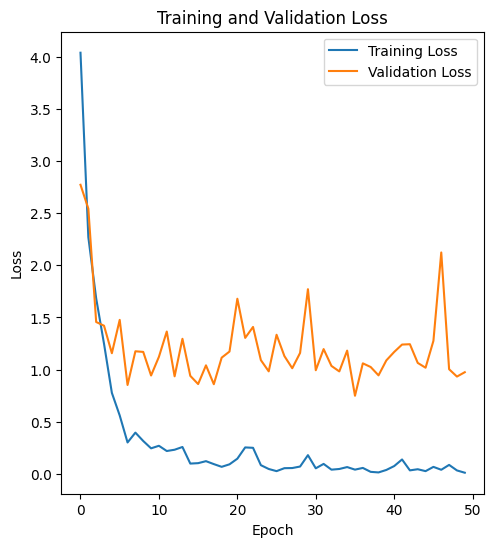

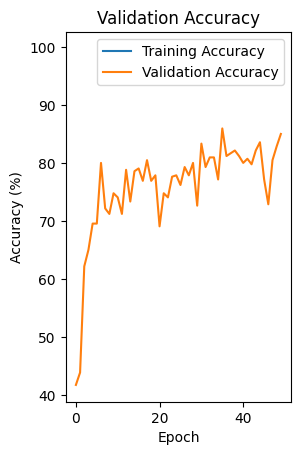

In [ ]:
# Plotting the training and validation metrics
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title(' Training Accuracy and Validation Accuracy')
plt.legend()

plt.show()



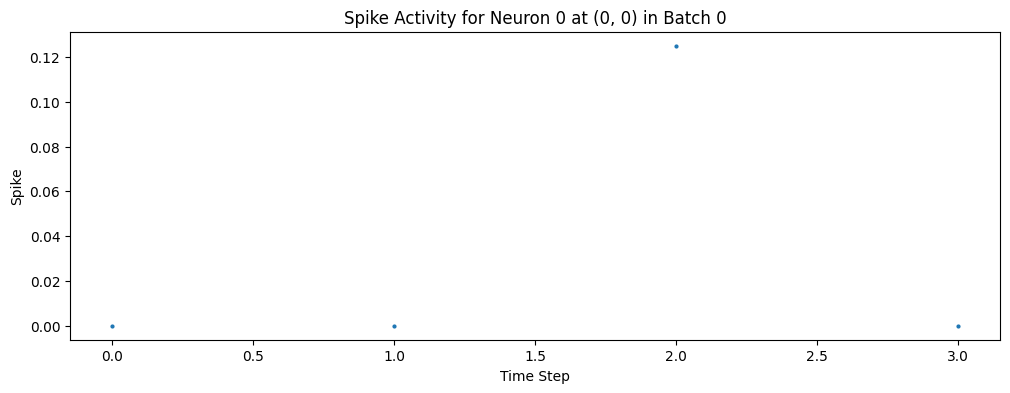

In [ ]:
import matplotlib.pyplot as plt

def plot_spikes(spike_tensor, batch_idx=0, neuron_idx=0, height_idx=0, width_idx=0):
    """
    Plots the spike activity over time for a specific neuron and batch.
    
    Args:
    - spike_tensor (torch.Tensor): The tensor containing spike outputs of shape (batch_size, neurons, timesteps, height, width).
    - batch_idx (int): The index of the batch to plot.
    - neuron_idx (int): The index of the neuron to plot.
    - height_idx (int): The index of the height dimension to plot.
    - width_idx (int): The index of the width dimension to plot.
    """
    # Extract spikes for the specified batch, neuron, and spatial location
    spikes = spike_tensor[batch_idx, neuron_idx, :, height_idx, width_idx].detach().cpu().numpy()
    
    # Plot spikes
    plt.figure(figsize=(12, 4))
    plt.plot(spikes, 'o', markersize=2)
    plt.title(f"Spike Activity for Neuron {neuron_idx} at ({height_idx}, {width_idx}) in Batch {batch_idx}")
    plt.xlabel("Time Step")
    plt.ylabel("Spike")
    plt.show()

# Assuming spike_output is your tensor of shape (batch_size, neurons, timesteps, height, width)
# Example usage
plot_spikes(spike_output, batch_idx=0, neuron_idx=0, height_idx=0, width_idx=0)


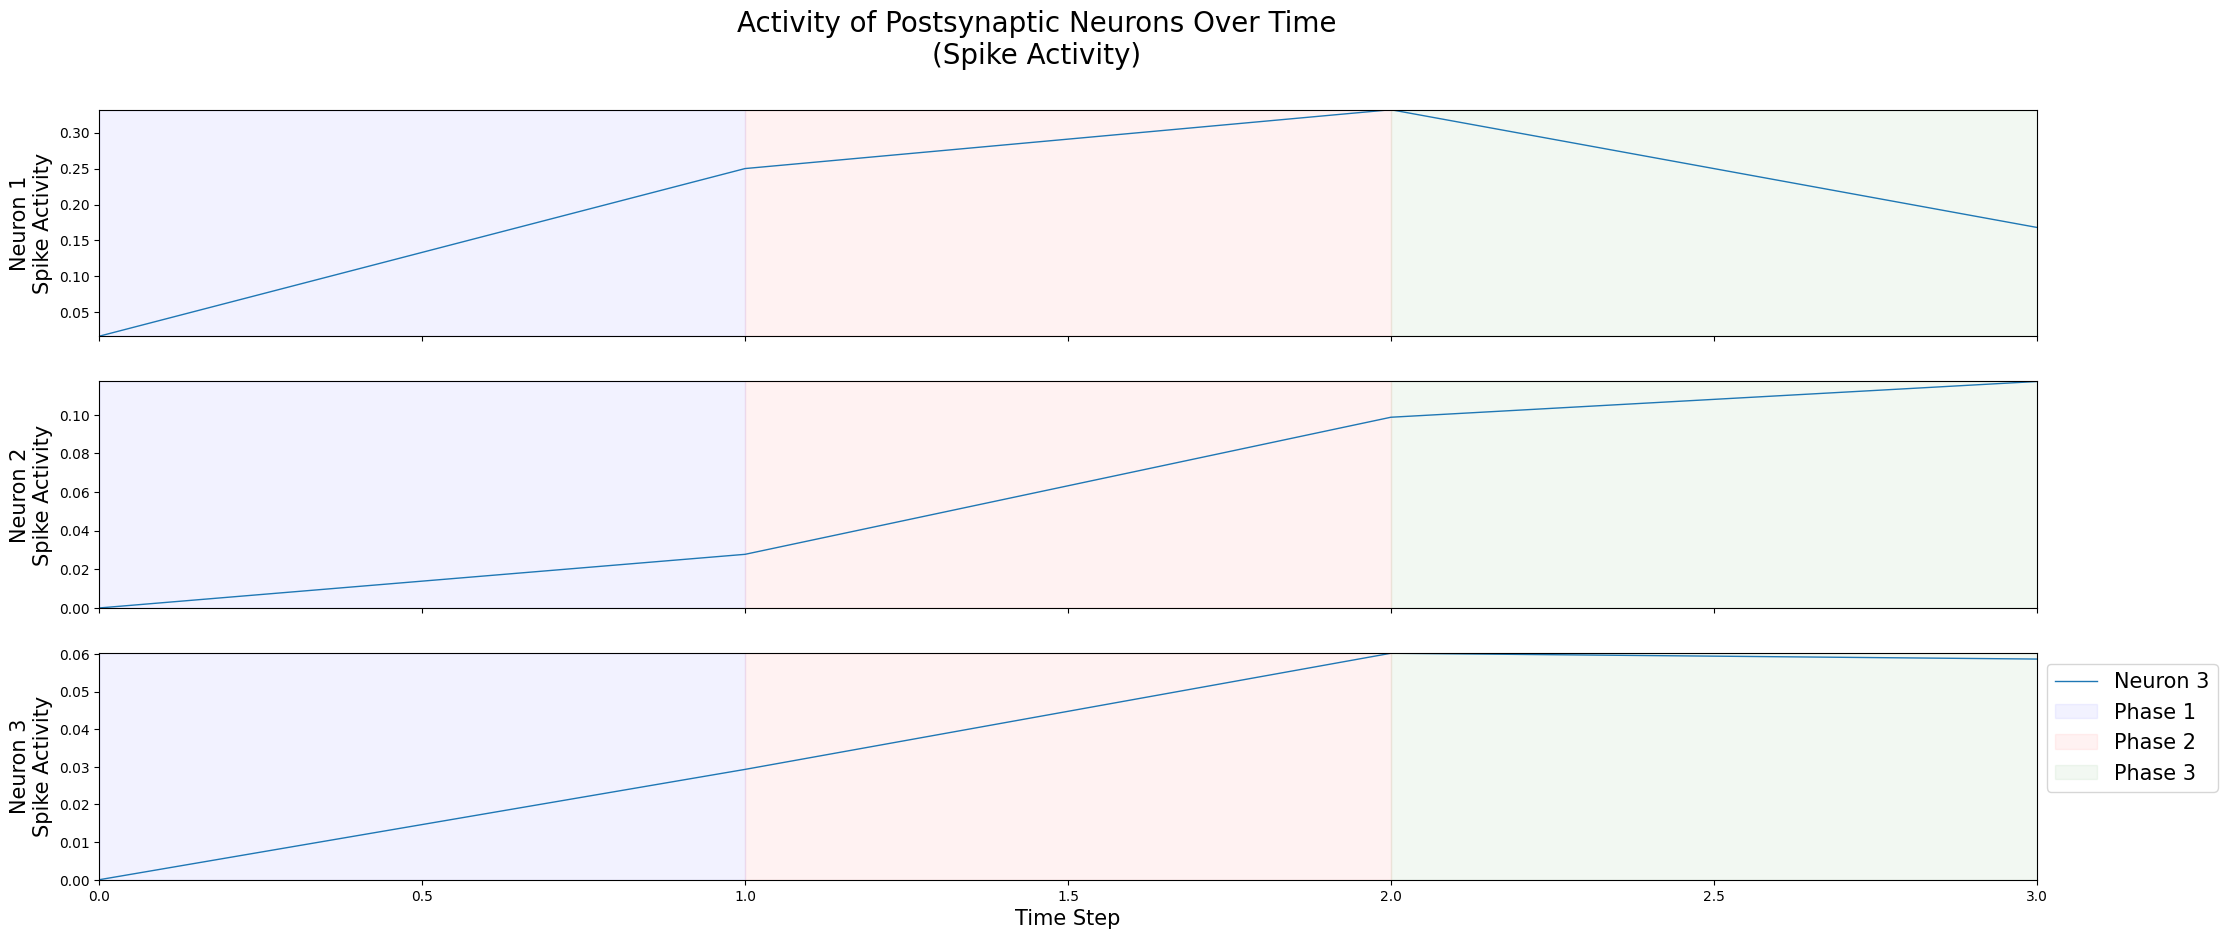

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def spike_plot(spike_tensor, num_neurons=3, batch_idx=0):
    """
    Plots the spike activity over time for multiple neurons.
    
    Args:
    - spike_tensor (torch.Tensor): The tensor containing spike outputs of shape (batch_size, neurons, timesteps, height, width).
    - num_neurons (int): Number of neurons to plot.
    - batch_idx (int): The index of the batch to plot.
    """
    # Extract spikes for the specified batch and reshape
    spikes = spike_tensor[batch_idx].detach().cpu().numpy()
    
    # Assuming the spatial dimensions are height x width
    height, width = spikes.shape[2], spikes.shape[3]
    time_steps = spikes.shape[1]
    
    fig, axes = plt.subplots(num_neurons, 1, figsize=(25, 10), sharex=True)
    if num_neurons == 1:
        axes = [axes]
        
    for neuron_idx in range(num_neurons):
        ax = axes[neuron_idx]
        neuron_spikes = spikes[neuron_idx].reshape(time_steps, -1)
        avg_spikes = np.mean(neuron_spikes, axis=1)  # Averaging over spatial dimensions
        
        ax.plot(np.arange(time_steps), avg_spikes, label=f'Neuron {neuron_idx + 1}', linewidth=1)
        ax.set_ylabel(f'Neuron {neuron_idx + 1}\nSpike Activity', fontsize=15)
        
        ax.axvspan(0, time_steps // 3, color='blue', alpha=0.05, label='Phase 1')
        ax.axvspan(time_steps // 3, 2 * time_steps // 3, color='red', alpha=0.05, label='Phase 2')
        ax.axvspan(2 * time_steps // 3, time_steps, color='green', alpha=0.05, label='Phase 3')
        
        ax.margins(0)
    
    plt.xlabel('Time Step', fontsize=15)
    plt.suptitle('Activity of Postsynaptic Neurons Over Time\n(Spike Activity)', fontsize=20)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=15)
    plt.show()

# Assuming spike_output is your tensor of shape (batch_size, neurons, timesteps, height, width)
# Example usage
spike_plot(spike_output, num_neurons=3, batch_idx=0)


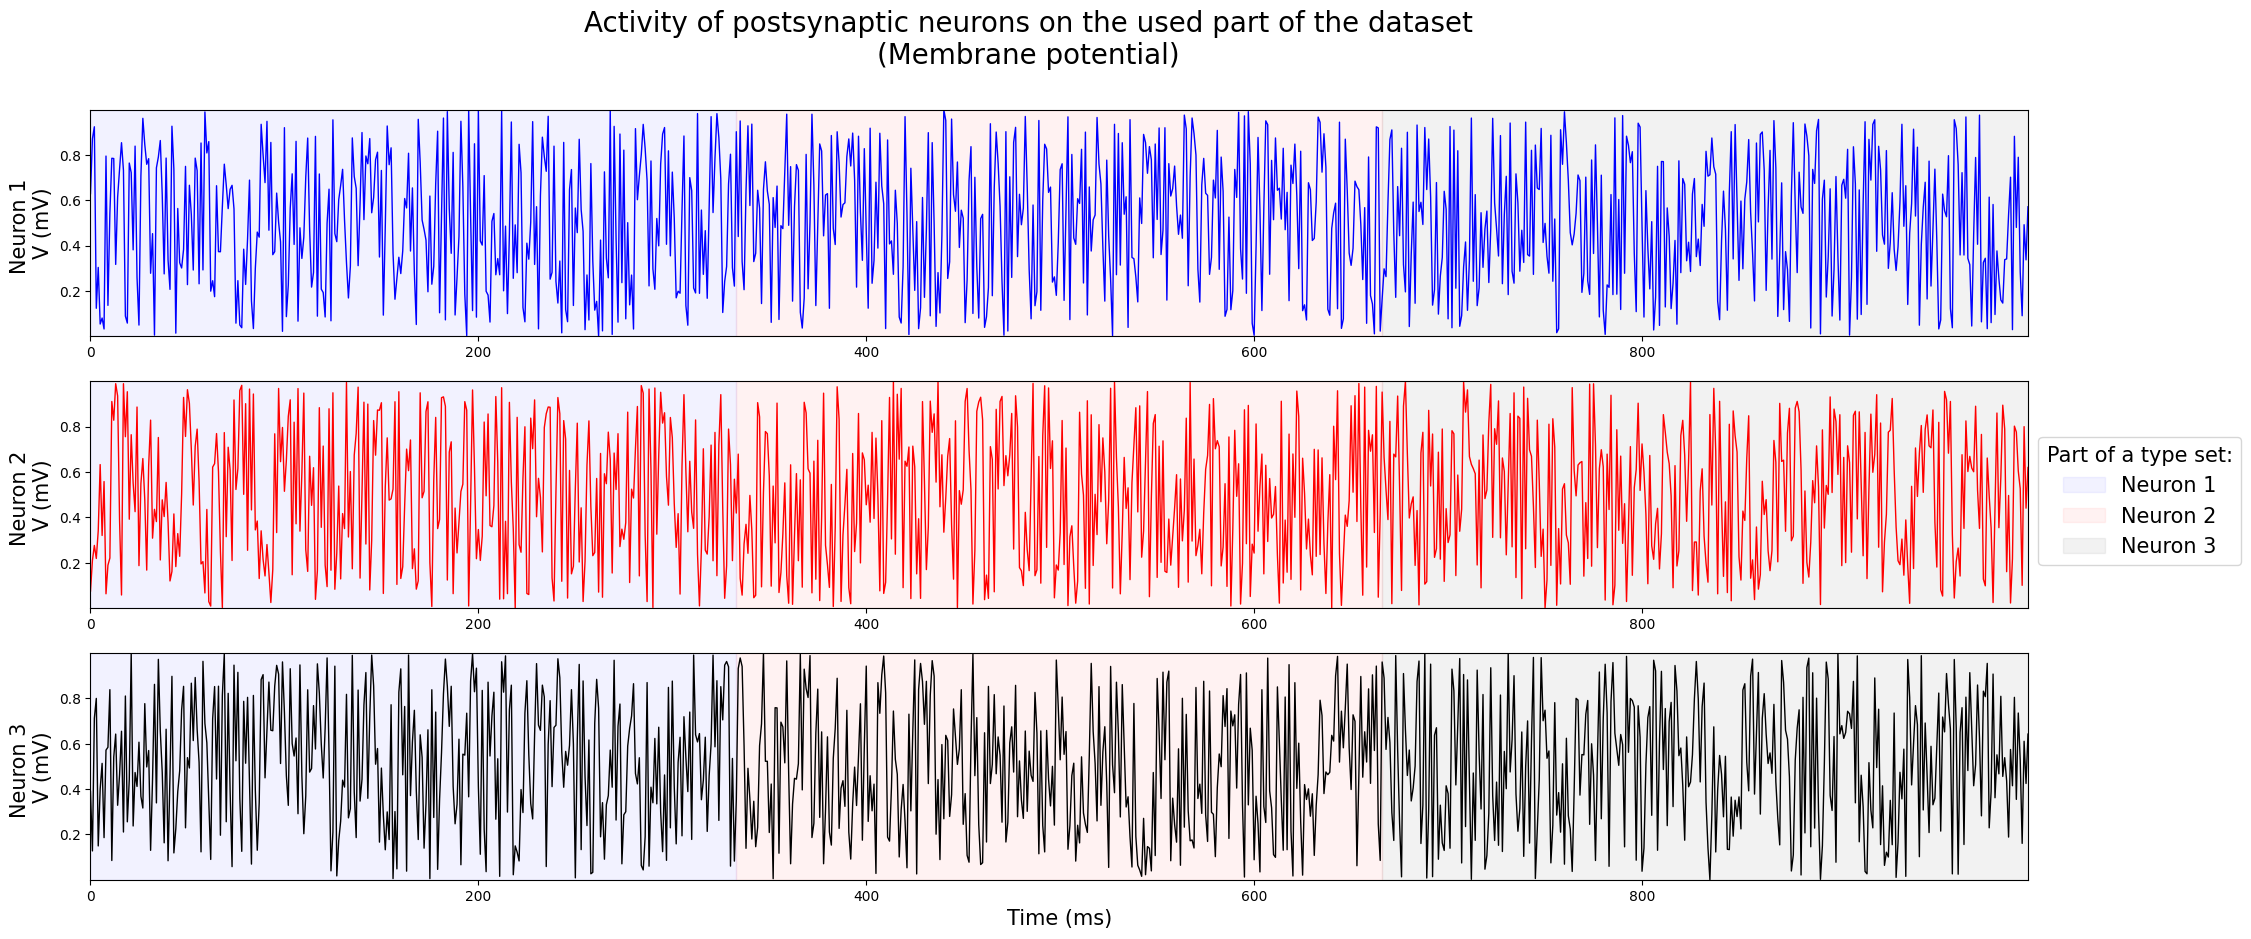

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_spiking_activity(spike_tensor, num_neurons_to_plot=3):
    """
    Plots the spike activity over time for a subset of neurons in a batch.
    
    Args:
    - spike_tensor (torch.Tensor): The tensor containing spike outputs of shape (batch_size, neurons, timesteps).
    - num_neurons_to_plot (int): The number of neurons to plot. Default is 3.
    """
    # Assuming spike_tensor shape is (batch_size, neurons, timesteps)
    batch_size, num_neurons, timesteps = spike_tensor.shape

    fig, axes = plt.subplots(num_neurons_to_plot, figsize=(25, 10))
    if num_neurons_to_plot == 1:
        axes = [axes]

    colors = ['blue', 'red', 'black']
    labels = [f'Neuron {i+1}' for i in range(num_neurons_to_plot)]

    for p in range(num_neurons_to_plot):
        ax = axes[p]
        neuron_idx = p  # Change this to select specific neurons if needed
        spikes = spike_tensor[0, neuron_idx, :].detach().cpu().numpy()

        ax.plot(np.arange(timesteps), spikes, color=colors[p % len(colors)], linewidth=1)
        ax.set_ylabel(f'{labels[p]} \nV (mV)', fontsize=15)
        ax.axvspan(0, timesteps // 3, color=colors[0], alpha=0.05, label=labels[0])
        ax.axvspan(timesteps // 3, 2 * timesteps // 3, color=colors[1], alpha=0.05, label=labels[1])
        ax.axvspan(2 * timesteps // 3, timesteps, color=colors[2], alpha=0.05, label=labels[2])
        ax.margins(0)

    plt.legend(title="Part of a type set:", bbox_to_anchor=(1, 2), loc='upper left', fontsize=15, title_fontsize=15)
    plt.xlabel('Time (ms)', fontsize=15)
    plt.suptitle('Activity of postsynaptic neurons on the used part of the dataset\n(Membrane potential)', fontsize=20)
    plt.show()

# Example usage with a dummy spike_tensor
# Assume spike_tensor is of shape (batch_size, neurons, timesteps)
dummy_spike_tensor = torch.rand(1, 10, 1000)  # (batch_size, neurons, timesteps)
plot_spiking_activity(dummy_spike_tensor, num_neurons_to_plot=3)
